# Extract cancer variant reads for alignment visualization

## In this notebook, we use a single RNA-seq fastq file from a melanoma cancer cell line from the the CCLE project. Learn more about the project here:
- sequencing data (ENA): https://www.ebi.ac.uk/ena/browser/view/PRJNA523380
- paper: https://www.nature.com/articles/s41586-019-1186-3

### Requirements: kb, samtools, and bowtie2

In [1]:
try:
    import varseek as vk
except ImportError:
    print("varseek not found, installing...")
    !pip install -U -q varseek
try:
    import RLSRWP_2025
except ImportError:
    print("RLSRWP_2025 not found, installing...")
    !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git

In [ ]:
import anndata
import os
import subprocess
from datetime import datetime
import numpy as np
import pandas as pd
import gget
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import time
import pyfastx
import glob
import requests
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
# pd.set_option('display.max_columns', None)
import varseek as vk
from varseek.utils import make_bus_df, add_variant_type

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025
threads = "32"

### File path definitions and imports

ENST00000390312:c.218G>A       1848.0
ENST00000336023:c.614A>G       1493.0
ENST00000579721:c.870G>C       1464.0
ENST00000496168:c.382G>A       1382.0
ENST00000579721:c.41C>T        1346.0

In [ ]:
notebook_out_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_data_base", "E_GEUV_1_HG00377_1_M_120209_6", "vk_count_out_w37_k41_combined_final")
aligned_reads_parent_dir = os.path.join(notebook_out_dir, "pseudoaligned_reads_to_vcrs_reference")
bowtie_read_alignments = os.path.join(notebook_out_dir, "bowtie_read_alignments_NOT_modified_bam")
detailed_txt_out = os.path.join(notebook_out_dir, "detailed_out_NOT_modified_bam.txt")
overall_txt_out = os.path.join(notebook_out_dir, "overall_out_NOT_modified_bam.txt")

# fp df
fp_df_path = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_analysis", "fp_df.parquet")
number_of_variants = None  # sorted by counts descending; None for all
hgvs_df_path = os.path.join(RLSRWP_2025_dir, "data", "reference", "geuvadis", "variants_transcriptome.parquet")

# vk ref out directory and files - downloaded if not already present
vk_ref_out_dir = os.path.join(RLSRWP_2025_dir, "data", "vk_ref_out_geuvadis", "w37_k41")
vcrs_index = os.path.join(vk_ref_out_dir, "vcrs_index.idx")
vcrs_t2g = os.path.join(vk_ref_out_dir, "vcrs_t2g_filtered.txt")
vcrs_fasta = os.path.join(vk_ref_out_dir, "vcrs_filtered.fa")

# fastq directories - fastqs_dir downloaded if not already present, and fastqs_processed_dir created with fastp if not already present
fastqs_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_data_base", "E_GEUV_1_HG00377_1_M_120209_6")
fastq_files = [os.path.join(fastqs_dir, "ERR204838_1.fastq.gz"), os.path.join(fastqs_dir, "ERR204838_2.fastq.gz")]
fastq_file = os.path.join(fastqs_dir, "fastqs_combined", "fastqs_combined.fastq.gz")  # os.path.join(fastqs_dir, "ERR204838_1.fastq.gz")
technology = "bulk"

# reference genome directory
reference_genome_dir = os.path.join(RLSRWP_2025_dir, "data", "reference", "ensembl_grch37_release113")
reference_genome_fasta = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.dna.primary_assembly.fa")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf
reference_genome_gtf = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.87.gtf")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf

# for bowtie2 - also uses reference_genome_fasta above (I could use cdna instead of genome too if desired)
bowtie_reference_dir = os.path.join(reference_genome_dir, "bowtie_index_genome")
bowtie_reference_prefix = os.path.join(bowtie_reference_dir, "index")

# general
w = "37"  # used during creation of the index, so cannot be altered
k = "41"  # used during creation of the index, so cannot be altered
strand = "unstranded"
parity = "single"
mm = True
union = True
use_combined = True
modify_bam = False  # convert 256 flag to 0

# software
bustools = "/home/jmrich/miniconda3/envs/varseek2/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools"
bowtie2 = "bowtie2"
bowtie2_build = "bowtie2-build"
samtools = "samtools"

### Make bowtie2 index files

In [4]:
if not os.path.exists(bowtie_reference_dir) or len(os.listdir(bowtie_reference_dir)) == 0:
    os.makedirs(bowtie_reference_dir, exist_ok=True)
    !{bowtie2_build} --threads {threads} {reference_genome_fasta} {bowtie_reference_prefix}

### Load in FP df

In [5]:
fp_df = pd.read_parquet(fp_df_path)
fp_df = fp_df.sort_values("vcrs_count", ascending=False)
if number_of_variants is not None:
    fp_df = fp_df.head(number_of_variants)

fps = set(fp_df.index.tolist())
print(fps)
fp_df.head()

{'ENST00000225282:c.2108G>A', 'ENST00000507110:c.136G>C', 'ENST00000355703:c.887C>T', 'ENST00000366627:c.266T>A', 'ENST00000604045:c.177C>T', 'ENST00000371088:c.989C>T', 'ENST00000374982:c.649C>T', 'ENST00000272342:c.2530C>T', 'ENST00000416488:c.1125G>A', 'ENST00000337872:c.1080A>C', 'ENST00000338110:c.1336A>G', 'ENST00000360141:c.620G>A', 'ENST00000338110:c.1114C>T', 'ENST00000395676:c.1644G>A', 'ENST00000306729:c.852T>A', 'ENST00000347982:c.1470T>C', 'ENST00000280379:c.4547A>G', 'ENST00000252603:c.177C>T', 'ENST00000570321:c.48A>T', 'ENST00000390299:c.185G>C', 'ENST00000266022:c.3184G>A', 'ENST00000450833:c.863C>A', 'ENST00000274458:c.445T>G', 'ENST00000603600:c.183A>C', 'ENST00000301015:c.835G>T', 'ENST00000268379:c.1312G>A', 'ENST00000261263:c.499C>T', 'ENST00000390243:c.354C>T', 'ENST00000234420:c.338C>A', 'ENST00000299886:c.413G>A', 'ENST00000200453:c.1652G>A', 'ENST00000359568:c.5426C>T', 'ENST00000357003:c.634G>A', 'ENST00000570593:c.774C>T', 'ENST00000256593:c.292C>G', 'ENST00

,vcrs_count
gene_id,
ENST00000390312:c.218G>A,1848.0
ENST00000336023:c.614A>G,1493.0
ENST00000579721:c.870G>C,1464.0
ENST00000496168:c.382G>A,1382.0
ENST00000579721:c.41C>T,1346.0


### Make pyfastx index files

In [6]:
if use_combined:
    if not os.path.isfile(fastq_file):
        import gzip
        os.makedirs(os.path.dirname(fastq_file), exist_ok=True)
        def process_and_write(input_path, output_file, file_tag):
            with gzip.open(input_path, "rt") as f_in:
                for i, line in enumerate(f_in):
                    if i % 4 == 0 and line.startswith('@'):
                        line = f"@{file_tag}{line[1:]}"  # replace @ with @fileX
                    output_file.write(line)

        with gzip.open(fastq_file, "wt") as f_out:
            process_and_write(fastq_files[0], f_out, "file1")
            process_and_write(fastq_files[1], f_out, "file2")
else:
    fastq_file = fastq_files[0]

In [7]:
fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)

### Perform variant screening with varseek count

In [8]:
kb_count_out_dir = os.path.join(notebook_out_dir, "kb_count_out_vcrs")
adata_path = os.path.join(kb_count_out_dir, "counts_unfiltered", "adata.h5ad")

if not os.path.exists(adata_path):
    vk_count_output_dict = vk.count(
        fastqs=fastq_file,
        index=vcrs_index,
        t2g=vcrs_t2g,
        technology=technology,
        out=notebook_out_dir,
        k=k,
        strand=strand,
        parity=parity,
        threads=threads,
        mm=mm,
        union=union,
        disable_fastqpp=True,
        disable_clean=True,
        disable_summarize=True
        # quality_control_fastqs=True, cut_front=True, cut_tail=True  # equivalent to the fastp step above
        # qc_against_gene_matrix=qc_against_gene_matrix, reference_genome_index=reference_genome_index, reference_genome_t2g=reference_genome_t2g,
    )

### Map the reads to the VCRS to which they aligned

In [9]:
bus_df = make_bus_df(kb_count_out_dir, fastq_file_list=fastq_file, technology=technology, parity=parity, bustools=bustools, mm=mm)
bus_df = bus_df.drop(columns=["transcript_names"]).rename(columns={"gene_names": "variant_names"})
filtered_bus_df = bus_df[bus_df["variant_names"].apply(lambda x: len(x) == 1)]  # remove multi-mapping reads
# filtered_bus_df = filtered_bus_df.loc[filtered_bus_df['barcode'] == "AAAAAAAAAAAAAAAA"]  # since I'm only using the 1st file
filtered_bus_df["variant_names_str"] = filtered_bus_df["variant_names"].apply(lambda x: x[0])  # cast to string
filtered_bus_df = filtered_bus_df[(filtered_bus_df["variant_names_str"].isin(fps)) & (filtered_bus_df["counted_in_count_matrix"])]
print(f"Number of reads in filtered bus file: {len(filtered_bus_df)}")
filtered_bus_df.head()

18:17:23 - INFO - loading in transcripts
18:17:23 - INFO - loading in ec matrix
18:17:23 - INFO - loading in barcodes
Processing FASTQ headers: 30247010it [01:03, 475958.29it/s]
18:18:41 - INFO - loading in bus df
18:18:41 - INFO - Merging fastq header df and ec_df into bus df
18:19:03 - INFO - Determining what counts in count matrix
18:19:03 - INFO - Saving bus df to /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/kb_count_out_vcrs/bus_df.parquet
18:19:03 - INFO - Finished processing bus df


Number of reads in filtered bus file: 45170


/tmp/ipykernel_2826784/2196594269.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_bus_df["variant_names_str"] = filtered_bus_df["variant_names"].apply(lambda x: x[0])  # cast to string


,barcode,UMI,EC,read_index,fastq_header,file_index,variant_names,counted_in_count_matrix,count_matrix_value,variant_names_str
0,AAAAAAAAAAAAAAAA,T,0,110692,file1ERR204838.110693,0,[ENST00000564393:c.240C>T],True,1.0,ENST00000564393:c.240C>T
1,AAAAAAAAAAAAAAAA,T,1,110785,file1ERR204838.110786,0,[ENST00000579721:c.945G>A],True,1.0,ENST00000579721:c.945G>A
2,AAAAAAAAAAAAAAAA,T,2,111357,file1ERR204838.111358,0,[ENST00000579721:c.870G>C],True,1.0,ENST00000579721:c.870G>C
3,AAAAAAAAAAAAAAAA,T,3,112037,file1ERR204838.112038,0,[ENST00000483379:c.462C>T],True,1.0,ENST00000483379:c.462C>T
6,AAAAAAAAAAAAAAAA,T,6,114038,file1ERR204838.114039,0,[ENST00000579721:c.41C>T],True,1.0,ENST00000579721:c.41C>T


In [ ]:
# url = "https://grch37.rest.ensembl.org/vep/human/id"
# headers = {"Content-Type": "application/json"}

hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df = hgvs_df.merge(fp_df, how="left", left_on="header_cdna", right_index=True, suffixes=("", "_fp"))
hgvs_df = hgvs_df.loc[~hgvs_df['vcrs_count'].isna()].sort_values('vcrs_count', ascending=False)  # .sort_values('vcrs_id', ascending=True)
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

# for variant_name in sorted(filtered_bus_df["variant_names_str"].unique()):
#     if ";" in variant_name:
#         continue
    # print(f"{variant_name}: {variant_cdna_to_dbsnp_id[variant_name]}")
    # try:
    #     url_single = f"{url}/{variant_cdna_to_dbsnp_id[variant_name]}?hgvs=1"
    #     response = requests.get(url_single, headers=headers, timeout=10)
    #     response.raise_for_status()  # Raise an exception for HTTP errors
    #     data = response.json()
    #     hgvsg = data[0]["hgvsg"]
    #     print(f"HGVSg: {hgvsg}")

    # except Exception as e:  #* give up
    #     print(f"Error: {e}")

In [11]:
hgvs_df.head()

,dbsnp_id,transcript_ID,variant_cdna,strand,header_cdna,vcrs_count,vcrs_id
0,rs3737543,ENST00000390312,c.218G>A,+,ENST00000390312:c.218G>A,1848.0,vcrs_0
1,rs1057725,ENST00000336023,c.614A>G,-,ENST00000336023:c.614A>G,1493.0,vcrs_1
2,rs114818671,ENST00000579721,c.870G>C,None,ENST00000579721:c.870G>C,1464.0,vcrs_2
3,rs11546099,ENST00000496168,c.382G>A,-,ENST00000496168:c.382G>A,1382.0,vcrs_3
4,rs115527405,ENST00000579721,c.41C>T,None,ENST00000579721:c.41C>T,1346.0,vcrs_4


In [12]:
hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
filtered_bus_df["vcrs_ids"] = filtered_bus_df["variant_names_str"].map(hgvsc_to_vcrs_id_dict)
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

for vcrs_id in sorted(filtered_bus_df["vcrs_ids"].unique()):  # Get unique gene names
    # print(f"Processing {vcrs_id}")
    temp_df = filtered_bus_df[filtered_bus_df["vcrs_ids"] == vcrs_id]  # Filter

    gene_dir = os.path.join(aligned_reads_parent_dir, vcrs_id)
    os.makedirs(gene_dir, exist_ok=True)
    
    aligned_reads_file = os.path.join(gene_dir, "1.fastq")
    with open(aligned_reads_file, "w") as f:
        for header in temp_df['fastq_header']:
            sequence = fastq_indexed[header].seq
            qualities = fastq_indexed[header].qual
            f.write(f"@{header}\n{sequence}\n+\n{qualities}\n")

From dbSNP (roughly):
ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.23101523G>A chrom22
ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
ENST00000579721:c.41C>T: rs115527405
ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6

### Align (1) pulled out reads and (2) the VCRSs to the human genome to generate bam files:

In [13]:
import pysam

def make_all_alignments_primary(infile_path, outfile_path):
    infile = pysam.AlignmentFile(infile_path, "rb")
    outfile = pysam.AlignmentFile(outfile_path, "wb", template=infile)

    for read in infile:
        read.flag = read.flag & ~256  # remove secondary flag
        outfile.write(read)

    infile.close()
    outfile.close()

In [ ]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": "jmrich@caltech.edu"}

true_variants = []  # varseek FP where varseek was correct
false_variants = []  # varseek FP where varseek was incorrect
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out, 'w').close()  # starts the file from scratch

paths = glob.glob(aligned_reads_parent_dir + "/*/")
sorted_paths = sorted(paths, key=lambda x: int(x.rstrip('/').split('_')[-1]))

for folder in tqdm(sorted_paths, total=len(sorted_paths)):
    variant = folder.split("/")[-2]
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    outfolder = f"{bowtie_read_alignments}/{variant}"
    os.makedirs(outfolder, exist_ok=True)
    
    # Align reads to human ref using bowtie2
    variant_sam = os.path.join(outfolder, variant + "_reads.sam")
    if not os.path.isfile(variant_sam):
        subprocess.run(f"{bowtie2} --very-sensitive -k 30 -x {bowtie_reference_prefix} --quiet -p {threads} -q {aligned_reads_parent_dir}/{variant}/1.fastq -S {variant_sam}", shell=True, check=True)
    if not os.path.isfile(variant_sam) or os.path.getsize(variant_sam) == 0:
        false_variants.append(variant_header)
        write_mode = "a" if os.path.isfile(detailed_txt_out) else "w"
        with open(detailed_txt_out, write_mode) as f:
            f.write(f"{variant}\n")
            f.write(f"True variant: False\n")
            f.write(f"Observed alleles: 0\n")
            f.write(f"Sequencing depth: 0\n")
            f.write(f"Fraction of ref: 0/0 = 0.00\n")
            f.write(f"Fraction of alt: 0/0 = 0.00\n")
            f.write(f"Fraction of other (should be 0): 0/0 = 0.00\n")
            f.write("--------------------------------\n")
        continue

    # Convert sam to bam
    variant_bam = os.path.join(outfolder, variant + "_reads.bam")
    if not os.path.isfile(variant_bam):
        subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)
    
    # Sort bam file
    variant_bam_sorted_prefix = "final_" + variant + "_sorted_reads"
    variant_bam_sorted = os.path.join(outfolder, variant_bam_sorted_prefix + ".bam")
    if not os.path.isfile(variant_bam_sorted):
        subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

    # make all alignments primary
    if modify_bam:
        variant_bam_sorted_modified = os.path.join(outfolder, variant_bam_sorted_prefix + "_modified.bam")
        if not os.path.isfile(variant_bam_sorted_modified):
            make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
    else:
        variant_bam_sorted_modified = variant_bam_sorted
        
    # Create an index for the sorted bam file (creates a .bai file)
    bam_index_file = os.path.join(outfolder, variant_bam_sorted_modified + ".bai")
    if not os.path.isfile(bam_index_file):
        subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

    #* new stuff
    try:
        hgvs_df_row = hgvs_df.loc[hgvs_df['vcrs_id'] == variant]
        dbsnp_id = hgvs_df_row['dbsnp_id'].values[0]
        hgvsc = hgvs_df_row['header_cdna'].values[0]
        strand = hgvs_df_row['strand'].values[0]
        variant_counts = hgvs_df_row['vcrs_count'].values[0]
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = hgvs_df_row['transcript_ID'].values[0]
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= 2  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
            
        if true_variant:
            true_variants.append(variant_header)
        else:
            false_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out) else "w"
        with open(detailed_txt_out, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} | {variant_counts} reported counts\n")
            f.write(f"True variant: {true_variant}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

  0%|          | 0/1446 [00:00<?, ?it/s]

100%|██████████| 1446/1446 [1:13:24<00:00,  3.05s/it]


In [15]:
!cat {overall_txt_out}

Number of true variants: 1115
Number of false variants: 310
True variants list: ['ENST00000390312:c.218G>A', 'ENST00000336023:c.614A>G', 'ENST00000579721:c.870G>C', 'ENST00000496168:c.382G>A', 'ENST00000579721:c.41C>T', 'ENST00000579721:c.448C>T', 'ENST00000344063:c.819A>C', 'ENST00000336023:c.587G>A', 'ENST00000586096:c.69C>T', 'ENST00000452596:c.481G>C', 'ENST00000579721:c.142G>A', 'ENST00000335895:c.439A>G', 'ENST00000579721:c.945G>A', 'ENST00000416804:c.192A>G', 'ENST00000290541:c.755T>C', 'ENST00000293831:c.283G>A', 'ENST00000604405:c.320T>A', 'ENST00000311604:c.205C>T', 'ENST00000303577:c.864A>T', 'ENST00000343139:c.293G>A', 'ENST00000343139:c.245A>T', 'ENST00000398603:c.415A>G', 'ENST00000253452:c.77G>A', 'ENST00000579721:c.89G>A', 'ENST00000290299:c.510A>G', 'ENST00000392132:c.1613T>C', 'ENST00000603423:c.137G>A', 'ENST00000381683:c.1035T>C', 'ENST00000310144:c.1148C>T', 'ENST00000468879:c.292A>T', 'ENST00000285848:c.1221T>A', 'ENST00000368653:c.8564C>G', 'ENST00000267115:c.448

In [16]:
# !cat {detailed_txt_out}

In [17]:
print("Overall file: ", overall_txt_out)
print("Detailed file: ", detailed_txt_out)

Overall file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/overall_out.txt
Detailed file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/detailed_out.txt


In [18]:
hgvs_df['true_variant'] = hgvs_df['header_cdna'].isin(set(true_variants))
hgvs_df.loc[hgvs_df['vcrs_id'].isna(), 'true_variant'] = pd.NA  # set the rows I didn't evaluate to NA

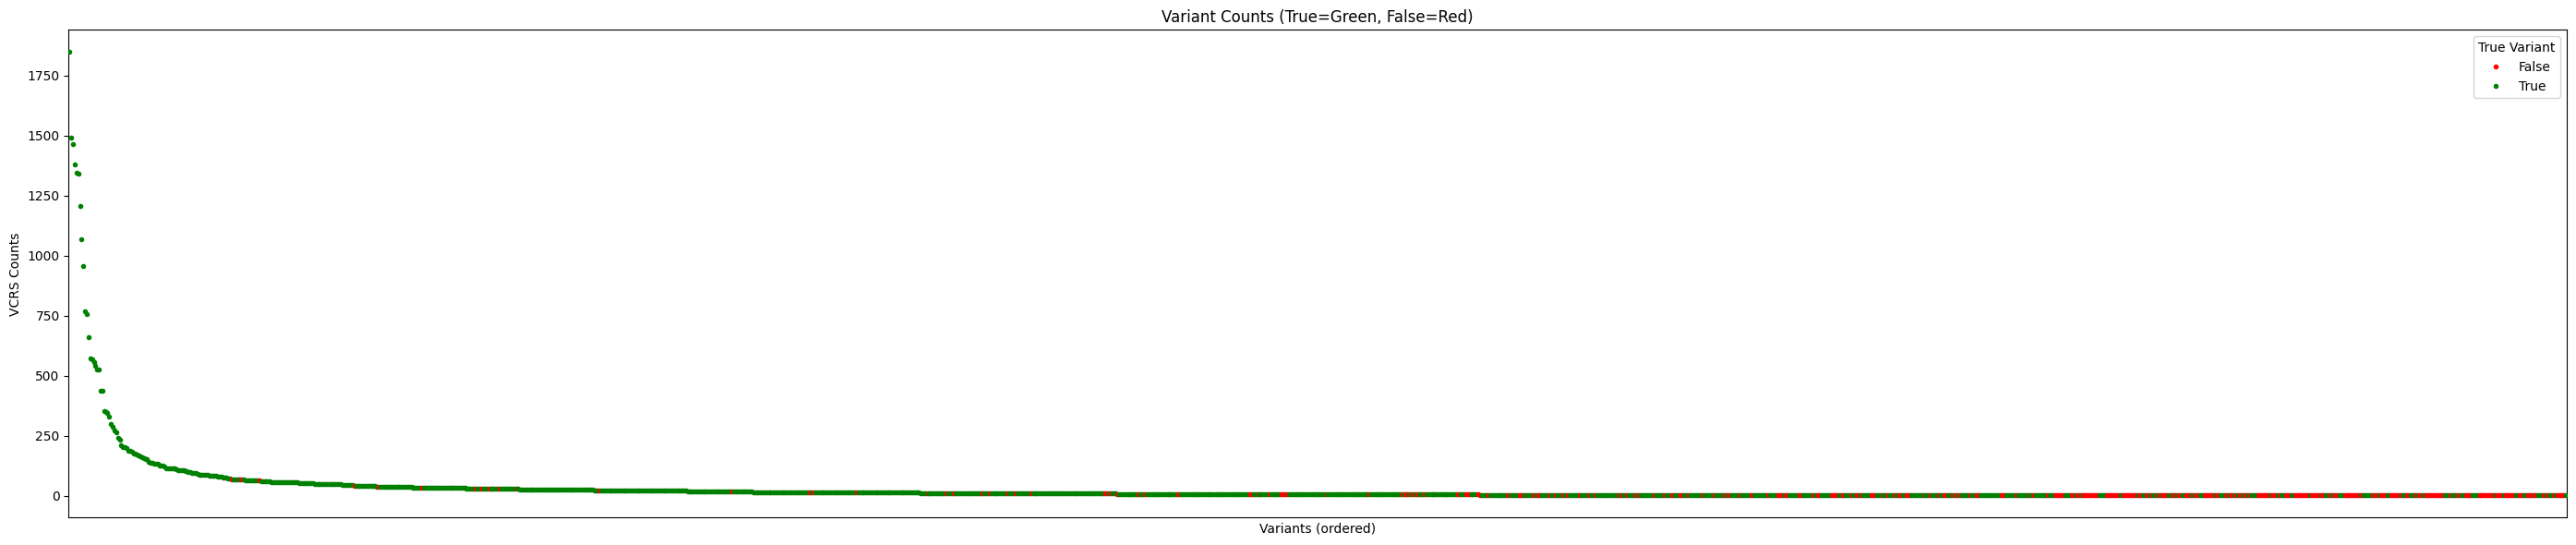

In [19]:
plt.figure(figsize=(28, 6))

# Sort by vcrs_count
# hgvs_df = hgvs_df.sort_values('vcrs_count', ascending=False)

sns.stripplot(
    data=hgvs_df,
    x='header_cdna',
    y='vcrs_count',
    hue='true_variant',
    dodge=False,
    palette={True: "green", False: "red"},
    size=4,
    jitter=0.4  # spread points slightly to reduce overlap
)

plt.xticks([], [])  # Hide x-axis ticks entirely
plt.xlabel('Variants (ordered)')
plt.ylabel('VCRS Counts')
plt.title('Variant Counts (True=Green, False=Red)')
plt.legend(title='True Variant', loc='upper right')
plt.tight_layout()

plt.show()


### Load the files in bowtie_read_alignments into NCBI Genome workbench (or another genome viewer) to visualize the alignments (the ones with "final_")

In [20]:
# # vcrs0: ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
# !samtools mpileup -r 2:89246969-89246969 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_0/final_vcrs_0_sorted_reads.bam

In [21]:
# # vcrs1: ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
# !samtools mpileup -r 12:49522578-49522578 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_1/final_vcrs_1_sorted_reads.bam

In [22]:
# # vcrs3: ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.22759034G>A chrom22
# !samtools mpileup -r 22:23101523-23101523 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_3/final_vcrs_3_sorted_reads.bam

In [23]:
# # vcrs4: ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6
# !samtools mpileup -r 6:29912149-29912149 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_4/final_vcrs_4_sorted_reads.bam

## Now look at FNs - roughly the same

In [ ]:
fn_txt_path = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_analysis", "fns.txt")
number_of_variants = None

bowtie_read_alignments_fn = os.path.join(notebook_out_dir, "bowtie_read_alignments_FNs_NOT_modified_bam")
detailed_txt_out_fn = os.path.join(notebook_out_dir, "detailed_out_fn_NOT_modified_bam.txt")
overall_txt_out_fn = os.path.join(notebook_out_dir, "overall_out_fn_NOT_modified_bam.txt")

In [25]:
with open(fn_txt_path) as f:
    fn_set = set(line.strip() for line in f)

In [26]:
hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df["is_false_negative"] = hgvs_df["header_cdna"].isin(fn_set)
hgvs_df = hgvs_df.loc[hgvs_df['is_false_negative']]
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [27]:
hgvs_df.head()

,dbsnp_id,transcript_ID,variant_cdna,strand,header_cdna,is_false_negative,vcrs_id
0,rs4970441,ENST00000338591,c.716G>C,+,ENST00000338591:c.716G>C,True,vcrs_0
1,rs3829740,ENST00000379407,c.1385G>C,+,ENST00000379407:c.1385G>C,True,vcrs_1
2,rs8997,ENST00000379389,c.445A>G,+,ENST00000379389:c.445A>G,True,vcrs_2
3,rs2465128,ENST00000379370,c.3116A>G,+,ENST00000379370:c.3116A>G,True,vcrs_3
4,rs10267,ENST00000379370,c.3608T>C,+,ENST00000379370:c.3608T>C,True,vcrs_4


In [40]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": "jmrich@caltech.edu"}

true_variants = []  # varseek FN where varseek was incorrect
false_variants = []  # varseek FN where varseek was correct
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out_fn, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    outfolder = f"{bowtie_read_alignments_fn}/{variant}"
    os.makedirs(outfolder, exist_ok=True)

    #* new stuff
    try:
        dbsnp_id = row['dbsnp_id']
        hgvsc = row['header_cdna']
        strand = row['strand']
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = row['transcript_ID']
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= 2  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
            
        if true_variant:
            true_variants.append(variant_header)
        else:
            false_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out_fn) else "w"
        with open(detailed_txt_out_fn, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} \n")
            f.write(f"True variant: {true_variant}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out_fn, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

23:16:37: Entering the loop


100%|██████████| 4863/4863 [51:01<00:00,  1.59it/s]  


In [41]:
!cat {overall_txt_out_fn}

Number of true variants: 1277
Number of false variants: 3430
True variants list: ['ENST00000338591:c.716G>C', 'ENST00000379389:c.445A>G', 'ENST00000379370:c.3116A>G', 'ENST00000379370:c.3608T>C', 'ENST00000379370:c.4211T>C', 'ENST00000379370:c.6107C>T', 'ENST00000346387:c.629C>T', 'ENST00000320498:c.565T>C', 'ENST00000235332:c.668A>G', 'ENST00000263932:c.1111C>T', 'ENST00000375199:c.1031G>C', 'ENST00000374651:c.2748G>A', 'ENST00000374561:c.681A>G', 'ENST00000374472:c.1176C>G', 'ENST00000374472:c.1161G>A', 'ENST00000374472:c.1008T>C', 'ENST00000374472:c.913T>C', 'ENST00000374472:c.822G>A', 'ENST00000374472:c.627C>T', 'ENST00000374472:c.351A>G', 'ENST00000374472:c.350A>G', 'ENST00000374213:c.180A>G', 'ENST00000374213:c.184A>G', 'ENST00000374166:c.194T>G', 'ENST00000374162:c.438T>C', 'ENST00000318074:c.1769A>G', 'ENST00000373485:c.526T>C', 'ENST00000316156:c.1698T>C', 'ENST00000317713:c.823G>A', 'ENST00000289893:c.6017C>T', 'ENST00000289893:c.6206C>A', 'ENST00000289893:c.15646G>C', 'ENST0

In [ ]:
# !cat {detailed_txt_out_fn}

In [44]:
print("Overall file: ", overall_txt_out_fn)
print("Detailed file: ", detailed_txt_out_fn)

Overall file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/overall_out_fn.txt
Detailed file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/detailed_out_fn.txt


## Analyze a FN

In [ ]:
# detailed_txt_out_fn = "/home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/detailed_out_fn_NOT_modified_bam.txt"
# vcrs_fasta = "/data/vk_ref_out_geuvadis/w37_k41/vcrs_filtered.fa"

variants_in_vcrs_reference = []
variants_not_in_vcrs_reference = []

with open(vcrs_fasta) as f:
    vcrs_reference_contents = f.read()

# loop through detailed_txt_out_fn and check if the variant was in the vcrs_fasta
with open(detailed_txt_out_fn) as f:
    lines = f.readlines()

for i in tqdm(range(len(lines))):
    if i + 1 < len(lines) and "True variant: False" in lines[i + 1]:
        continue  # I only want to analyze True variants that varseek missed
    line = lines[i]
    if not line.startswith("vcrs"):
        continue
    parts = line.strip().split("|")
    if len(parts) < 3:
        continue
    mutation_str = parts[2].strip()  # e.g., ENST00000338591:c.716G>C
    if mutation_str in vcrs_reference_contents:
        variants_in_vcrs_reference.append(mutation_str)
    else:
        variants_not_in_vcrs_reference.append(mutation_str)

print(f"Variants in vcrs_reference: {len(variants_in_vcrs_reference)}")
print(f"Variants not in vcrs_reference: {len(variants_not_in_vcrs_reference)}")

100%|██████████| 37656/37656 [00:12<00:00, 3113.69it/s]

Variants in vcrs_reference: 54
Variants not in vcrs_reference: 1161


In [15]:
variants_in_vcrs_reference[:20]

['ENST00000374472:c.351A>G',
 'ENST00000374472:c.350A>G',
 'ENST00000340450:c.795T>G',
 'ENST00000340450:c.801T>G',
 'ENST00000370139:c.96G>A',
 'ENST00000370139:c.97C>T',
 'ENST00000581821:c.709G>C',
 'ENST00000355199:c.1215G>C',
 'ENST00000486442:c.1197T>C',
 'ENST00000349938:c.732A>G',
 'ENST00000349938:c.733T>A',
 'ENST00000342518:c.1024C>T',
 'ENST00000389851:c.639T>C',
 'ENST00000322602:c.659T>C',
 'ENST00000419065:c.381G>C',
 'ENST00000419065:c.406T>C',
 'ENST00000548145:c.677C>T',
 'ENST00000548145:c.683C>T',
 'ENST00000548145:c.791C>T',
 'ENST00000550817:c.7A>C']

In [ ]:
# look into detailed_txt_out_fn and pick a True variant that had reads align to ALT and is in the vcrs reference
# eg vcrs_104 | rs2502992 | ENST00000374472:c.351A>G | (-) strand | 1:g.24201919T>C 
# variant_bam_sorted_modified = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/final_total_sorted_reads_modified.bam"  #* uncomment if running only this bottom portion
hgvsc = "ENST00000374472:c.351A>G"
chrom = "1"
pos = "24201919"

# output_sam = f"/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/reads_at_{chrom}_{pos}.sam"
output_sam = os.path.join(notebook_out_dir, f"reads_at_{chrom}_{pos}.sam")
!samtools view {variant_bam_sorted_modified} {chrom}:{pos}-{pos} > {output_sam}

In [ ]:
output = !grep -A 1 "{hgvsc}" {vcrs_reference}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)
print(seq_rc[:38])
print(seq_rc[37:])

ACGTGGCTGTGCTCTATCTGATCCTGTCCTCCCACCAGCTCCGCCGGAAGCCCTCATACCTGTTCATTGGCAGCT
AGCTGCCAATGAACAGGTATGAGGGCTTCCGGCGGAGCTGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGT
AGCTGCCAATGAACAGGTATGAGGGCTTCCGGCGGAGC
CTGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGT


(double click on this cell for it to make sense)

In this case, the issue was due to multiple variants - all reads had the variant toward the left end of the read, and there is another variant to the right that blocks a perfect k-mer match (also, keep in mind that read length is 75 for this dataset and w=37/k=41, so the reads are relatively small)

Eg typical read:
TTCCGGCGGAGCCGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGTTCTCCAGGGCACTTAGCAGGCCCAGA  # read
TTCCGGCGGAGCTGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGT  # vcrs fragment aligned to read
           *
            ^

* mutation side for VCRS
^ unrelated mutation that blocks k-mer match

## Now let's look into a FP

In [35]:
# eg vcrs_100 | rs1131095 | ENST00000296456:c.1252T>C | (+) strand | 3:g.49714225T>C | 68.0 reported counts
hgvsc = "ENST00000296456:c.1252T>C"
output = !grep -A 1 "{hgvsc}" {vcrs_reference}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)

TCCGCTTTTGCACCAATCGCAGGTCAGCCCTGTATTACGTGGACCTCATCGGGGGGAAGTGTGAGCTCCTCTCGG
CCGAGAGGAGCTCACACTTCCCCCCGATGAGGTCCACGTAATACAGGGCTGACCTGCGATTGGTGCAAAAGCGGA


### Manually check if any read has a k-mer that matches the VCRS

In [44]:
# import pyfastx
# fastq_file = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/fastqs_combined/fastqs_combined.fastq.gz"  #* uncomment if running only this bottom portion
# fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)  #* uncomment if running only this bottom portion

k = 41  # from vk ref settings
kmer_set = set()

# Add k-mers from seq and seq_rc
for s in [seq, seq_rc]:
    for i in range(len(s) - k + 1):
        kmer_set.add(s[i:i+k])

# Store reads that contain any of those k-mers
matching_reads = {}

fq_read_only = pyfastx.Fastx(fastq_file)

for name, read_seq, _ in tqdm((fq_read_only), total=len(fastq_indexed)):
    found = any(read_seq[i:i+k] in kmer_set for i in range(len(read_seq) - k + 1))
    if found:
        matching_reads[name] = read_seq

  0%|          | 0/30247010 [00:00<?, ?it/s]

100%|██████████| 30247010/30247010 [06:10<00:00, 81664.83it/s]


In [46]:
matching_reads

{'file1ERR204838.34043': 'TGAGCCCTTCCGGTTGGGCATCCGCTTTTGCACCAATCGCAGGTCAGCCCTGTATTACGTGGACCTCATCGGGGG',
 'file1ERR204838.456710': 'GATGAGGTCCACGTAATACAGGGCTGACCTGCGATTGGTGCAAAAGCGGATGCCCAACCGGAAGGGCTCATGCCA',
 'file1ERR204838.807859': 'CCGATGAGGTCCACGTAATACAGGGCTGACCTGCGATTGGTGCAAAAGCGGATGCCCAACCGGAAGGGCTCATGC',
 'file1ERR204838.1165745': 'TTGGGCATCCGCTTTTGCACCAATCGCAGGTCAGCCCTGTATTACGTGGACCTCATCGGGGGGAAGTGTGAGCTC',
 'file1ERR204838.1188941': 'CCGATGAGGTCCACGTAATACAGGGCTGACCTGCGATTGGTGCAAAAGCGGATGCCCAACCGGAAGGGCTCATGC',
 'file1ERR204838.1588404': 'GTGGCATGAGCCCTTCCGGTTGGGCATCCGCTTTTGCACCAATCGCAGGTCAGCCCTGTATTACGTGGACCTCAT',
 'file1ERR204838.1627292': 'ATCCGCTTTTGCACCAATCGCAGGTCAGCCCTGTATTACGTGGACCTCATCGGGGGGAAGTGTGAGCTCCTCTCG',
 'file1ERR204838.2165726': 'GGGGAGAAGAGACAGCCAGGGAGTCATCCGAGAGGAGCTCACACTTCCCCCCGATGAGGTCCACGTAATACAGGG',
 'file1ERR204838.2636927': 'TGGGGAGAAGAGACAGCCAGGGAGTCATCCGAGAGGAGCTCACACTTCCCCCCGATGAGGTCCACGTAATACAGG',
 'file1ERR204838.3557423': 'CCCCGATGAGGTCCACGTAATA

In [ ]:
# variant_sam = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/total_reads.sam"
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")

mapped_reads = []
unmapped_reads = []
for read in tqdm(matching_reads, total=len(matching_reads)):
    # output = !grep -P '^file1ERR204838\.34043\t' {variant_sam}
    read_with_backslash = read.replace(".", "\.")
    output = !grep -P '^{read_with_backslash}\t' {variant_sam}
    individual_output_list_of_lists = []
    mapped = False
    for individual_output in output:
        individual_output_list = individual_output.split("\t")
        ref_seq_name = individual_output_list[2]
        if ref_seq_name != "*":
            mapped = True
            individual_output_list_of_lists.append(individual_output_list)
            # break
    if mapped:
        mapped_reads.append({read: individual_output_list_of_lists})
    else:
        unmapped_reads.append(read)
    # break

print(f"Number of mapped reads: {len(mapped_reads)}")
print(f"Number of unmapped reads: {len(unmapped_reads)}")

100%|██████████| 68/68 [19:41<00:00, 17.38s/it]

Number of mapped reads: 5
Number of unmapped reads: 63


If desired, I could do additional analysis to go through mapped_reads and determine if the read mapped to the correct place; but this is probably unnecessary.